# This is for both heuristics

In [1]:
from shapely.geometry import Polygon
from sqlite3 import connect
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt


# Now this time page-3 is with the corrected overlap measurement
# And pages 4 is with multires, keeping at most 8 patch sizes, bbox_threshold=0.5
conn = connect('../data/charts_coarse.db')
df = pd.read_sql('select * from `pages-5`', conn)
xdf = df.dropna(subset=['annotations', 'prediction'])
xdf = xdf[['annotations', 'prediction']]

In [2]:
def get_coords(row):
    x, y, h, w = row.x, row.y, row.height, row.width
    return (x, y), (x + w, y), (x + w, y + h), (x, y + h)

def get_dfs(row):
    annotation, prediction = map(json.loads, row.tolist())
    y_true = [v['value'] for v in annotation]
    y_true = pd.DataFrame.from_records([
        {k: v[k] for k in ['x', 'y', 'height', 'width', 'rectanglelabels']} for v in y_true
    ])
    y_pred = [v['value'] for v in prediction]
    y_pred = pd.DataFrame.from_records([
        {k: v[k] for k in ['x', 'y', 'height', 'width', 'rectanglelabels']} for v in y_pred
    ])
    y_true['label'] = y_true.pop('rectanglelabels').apply(lambda x: x[0])
    y_pred['label'] = y_pred.pop('rectanglelabels').apply(lambda x: x[0])
    return y_true, y_pred

def get_iou_matrix(row):
    y_true, y_pred = get_dfs(row)
    ious = {}
    for label in ['map', 'donut', 'line', 'scatter']:
        ltrue, lpred = y_true[y_true['label'] == label], y_pred[y_pred['label'] == label]
        if not any([len(ltrue), len(lpred)]):
            # If the label is absent in both annotation and prediction, continue to the next label
            continue
        
        elif len(ltrue) and not len(lpred):
            # Prediction is absent, annotation is present
            # Prediction is then a polygon with zero area
            pred_polygons = [Polygon([(0, 0), (0, 0), (0, 0), (0, 0)])]
            true_polygons = ltrue.apply(lambda row: Polygon(get_coords(row)), axis=1)
        elif len(lpred) and not len(ltrue):
            # Prediction present, annotation absent
            # Annotation is a polygon with zero area
            true_polygons = [Polygon([(0, 0), (0, 0), (0, 0), (0, 0)])]
            pred_polygons = lpred.apply(lambda row: Polygon(get_coords(row)), axis=1)
        else:
            true_polygons = ltrue.apply(lambda row: Polygon(get_coords(row)), axis=1)
            pred_polygons = lpred.apply(lambda row: Polygon(get_coords(row)), axis=1)
        iou = np.zeros(list(map(len, (pred_polygons, true_polygons))))
        for i, p_poly in enumerate(pred_polygons):
            for j, t_poly in enumerate(true_polygons):
                iou[i, j] = p_poly.intersection(t_poly).area / p_poly.union(t_poly).area
        ious[label] = iou
        
    return ious


def map_iou(row):
    mats = get_iou_matrix(row)
    thresh = np.arange(0.5, 1, 0.05)
    ious = {}
    for label, iou in mats.items():
        T = np.tile(thresh, iou.shape + (1,))
        X = np.repeat(iou[:, :, np.newaxis], 10, axis=2)
        threshed = X > T
        tp = threshed.any(axis=1).sum(axis=0)
        fp = (threshed.sum(axis=1) == 0).sum(axis=0)
        fn = (threshed.sum(axis=0) == 0).sum(axis=0)
        ious[label] = np.mean(tp / (tp + fp + fn))
    return ious

xdf

,annotations,prediction
0,"[{""original_width"":586,""original_height"":404,""...","[{""value"": {""x"": 66.66666666666666, ""y"": 31.03..."
1,"[{""original_width"":857,""original_height"":932,""...","[{""value"": {""x"": 62.06896551724138, ""y"": 78.37..."
2,"[{""original_width"":939,""original_height"":941,""...","[{""value"": {""x"": 17.24137931034483, ""y"": 13.79..."
3,"[{""original_width"":960,""original_height"":356,""...","[{""value"": {""x"": 70.12987012987013, ""y"": 62.06..."
4,"[{""original_width"":1024,""original_height"":1019...","[{""value"": {""x"": 65.51724137931035, ""y"": 48.27..."
5,"[{""original_width"":670,""original_height"":1024,...","[{""value"": {""x"": 48.275862068965516, ""y"": 34.0..."
6,"[{""original_width"":1024,""original_height"":768,...","[{""value"": {""x"": 0.0, ""y"": 13.793103448275861,..."
7,"[{""original_width"":500,""original_height"":500,""...","[{""value"": {""x"": 65.51724137931035, ""y"": 55.17..."
8,"[{""original_width"":1024,""original_height"":917,...","[{""value"": {""x"": 0.0, ""y"": 0.0, ""width"": 62.06..."
9,"[{""original_width"":1023,""original_height"":611,...","[{""value"": {""x"": 72.0, ""y"": 62.06896551724138,..."


In [3]:
xdf.drop(xdf[xdf['prediction'].map(json.loads).map(len) == 0].index, axis=0, inplace=True)

In [4]:
xdf

,annotations,prediction
0,"[{""original_width"":586,""original_height"":404,""...","[{""value"": {""x"": 66.66666666666666, ""y"": 31.03..."
1,"[{""original_width"":857,""original_height"":932,""...","[{""value"": {""x"": 62.06896551724138, ""y"": 78.37..."
2,"[{""original_width"":939,""original_height"":941,""...","[{""value"": {""x"": 17.24137931034483, ""y"": 13.79..."
3,"[{""original_width"":960,""original_height"":356,""...","[{""value"": {""x"": 70.12987012987013, ""y"": 62.06..."
4,"[{""original_width"":1024,""original_height"":1019...","[{""value"": {""x"": 65.51724137931035, ""y"": 48.27..."
5,"[{""original_width"":670,""original_height"":1024,...","[{""value"": {""x"": 48.275862068965516, ""y"": 34.0..."
6,"[{""original_width"":1024,""original_height"":768,...","[{""value"": {""x"": 0.0, ""y"": 13.793103448275861,..."
7,"[{""original_width"":500,""original_height"":500,""...","[{""value"": {""x"": 65.51724137931035, ""y"": 55.17..."
8,"[{""original_width"":1024,""original_height"":917,...","[{""value"": {""x"": 0.0, ""y"": 0.0, ""width"": 62.06..."
9,"[{""original_width"":1023,""original_height"":611,...","[{""value"": {""x"": 72.0, ""y"": 62.06896551724138,..."


In [5]:
def _map_iou(row):
    try:
        x = map_iou(row)
    except ZeroDivisionError:
        x = {}
    return x

In [6]:
label_ious = {}

for iou in xdf.apply(_map_iou, axis=1).tolist():
    for k, v in iou.items():
        if k in label_ious:
            label_ious[k].append(v)
        else:
            label_ious[k] = [v]

In [7]:
label_ious = {k: np.mean(v) for k, v in label_ious.items()}

<AxesSubplot:>

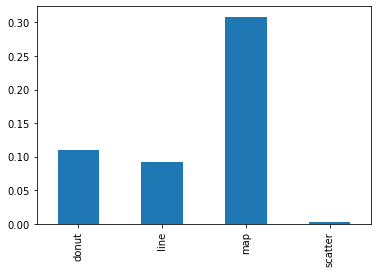

In [138]:
pd.Series(label_ious).plot(kind='bar')

In [12]:
# With the new heuristics

<AxesSubplot:>

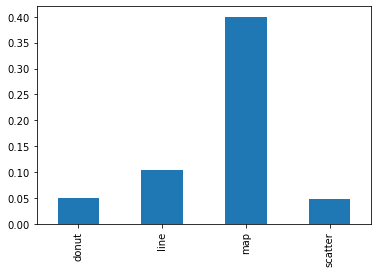

In [13]:
pd.Series(label_ious).plot(kind='bar')

<AxesSubplot:>

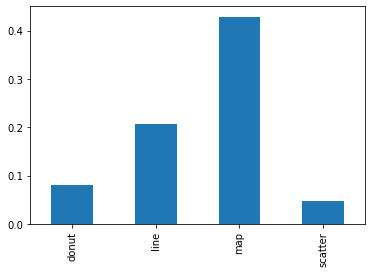

In [6]:
# With the corrected overlap measurement
pd.Series(label_ious).plot(kind='bar')

<AxesSubplot:>

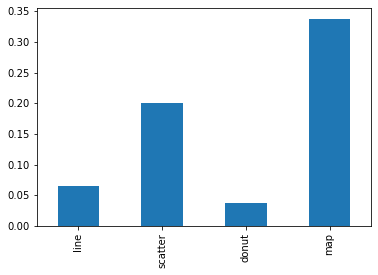

In [17]:
# With multires, pages-4
pd.Series(label_ious).plot(kind='bar')

<AxesSubplot:>

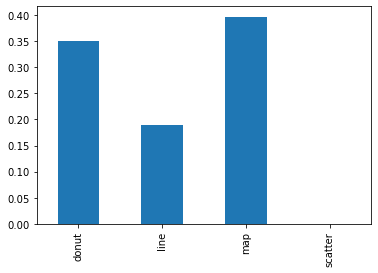

In [10]:
# For 2-8 patches each side, with dilation
pd.Series(label_ious).plot(kind='bar')
# xdf.apply(_map_iou, axis=1)

In [19]:
# For 2-8 patches each side, with dilation


,annotations,prediction
0,"[{""original_width"":2072,""original_height"":1554...","[{""value"": {""x"": 0.0, ""y"": 4.0, ""width"": 72.97..."
1,"[{""original_width"":586,""original_height"":404,""...","[{""value"": {""x"": 0.0, ""y"": 0.0, ""width"": 88.88..."
2,"[{""original_width"":857,""original_height"":932,""...","[{""value"": {""x"": 0.0, ""y"": 0.0, ""width"": 92.30..."
3,"[{""original_width"":939,""original_height"":941,""...","[{""value"": {""x"": 0.0, ""y"": 0.0, ""width"": 94.11..."
5,"[{""original_width"":1024,""original_height"":1019...","[{""value"": {""x"": 11.76470588235294, ""y"": 64.70..."


In [21]:
df.head()

,page_id,image,url,annotations,prediction
0,0,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",Wikipedia_search_referrals_dashboard.png,"[{""original_width"":2072,""original_height"":1554...","[{""value"": {""x"": 0.0, ""y"": 4.0, ""width"": 72.97..."
1,19,"data:image/png;base64,_9j_4AAQSkZJRgABAQEAYABg...",3_Dashboards.JPG,"[{""original_width"":586,""original_height"":404,""...","[{""value"": {""x"": 0.0, ""y"": 0.0, ""width"": 88.88..."
2,20,"data:image/png;base64,_9j_7QCGUGhvdG9zaG9wIDMu...",488630845_63de27b41f_b.jpg,"[{""original_width"":857,""original_height"":932,""...","[{""value"": {""x"": 0.0, ""y"": 0.0, ""width"": 92.30..."
3,21,"data:image/png;base64,_9j_4AAQSkZJRgABAQIAJQAl...",1805960013_14db7933b3_b.jpg,"[{""original_width"":939,""original_height"":941,""...","[{""value"": {""x"": 0.0, ""y"": 0.0, ""width"": 94.11..."
4,22,"data:image/png;base64,_9j_4AAQSkZJRgABAQIAHAAc...",1893633197_b0549aca92_b.jpg,"[{""original_width"":960,""original_height"":356,""...",[]
